In [200]:
# Imports --------------------------------------------------------------------------
using ForwardDiff
using LinearAlgebra
using LaTeXStrings
using NLsolve
using JLD
using Plots
using Traceur
using Printf

In [201]:
# Discretization setup -------------------------------------------------------------
const num_species = 4  # 'n'
const num_cells = 2000; # 'Q'
const dx = 1.0/num_cells; # '\Delta y'

const N_T = 1000; # 'M'
const T = 1000;
const dt = T / N_T

const grid1D = range(0, 1, length=num_cells) |> collect;
const time1D = range(dt, T, length=N_T) |> collect;

const cells1D = [(k-1/2)*dx for k=1:num_cells];
const x_left = [(k-1)*dx for k=1:num_cells];
const x_right = [k*dx for k=1:num_cells];

In [202]:
# Saving parameters ----------------------------------------------------------------
theme(:bright)
window = 700
adress = string("dt_",dt,"/1D_Flux_Ari__dt",dt,"_dx",dx)
saving = false 
initial_pfl = "var"

# Flux parameters ---------------------------------------------------------------
flux = "Ath"
var_flux = "var"; # cst for constant, var for variable

In [203]:
println("dx,dt : (",dx,",",dt,")")

dx,dt : (0.0005,1.0)


## Initial Condition ------------------------------------------------

In [204]:
M0 = Array{Float64, 2}(undef, num_cells, num_species);

if var_flux == "cst"
    s = @. cells1D^2 + abs(sin(pi*cells1D)) + 1

    M0[:,1] = @. exp( (-(cells1D-0.5)^2) / 0.04 )/ s;
    M0[:,2] = @. cells1D^2 / s;
    M0[:,3] = @. 1/ s - M0[:,1];
    M0[:,4] = @. abs(sin(pi*cells1D)) / s;
end

if var_flux == "var"
    s = @. 3*cells1D + sqrt(cells1D)
    M0[:,1] = @. (cells1D)/ s;
    M0[:,2] = @. 2* (cells1D) / s;
    M0[:,3] = @. (sqrt(cells1D)) / s;
    M0[:,4] = @. 0* cells1D / s;
 end

const U0 = reshape(M0, (num_cells * num_species,)); # transform to 1D vector

# Plotting
U01 = U0[1:num_cells];
U02 = U0[num_cells + 1:2*num_cells];
U03 = U0[2*num_cells + 1:3*num_cells];
U04 = U0[3*num_cells + 1:4*num_cells];

p1 = plot(cells1D, U01, label="Concentration of species 1",mark=:dot, xlabel=L"x", ylabel=L"U",ylims = (-0.1,1.1));
p2 = plot!(p1,cells1D, U02, label="Concentration of species 2",mark=:dot, xlabel=L"x", ylabel=L"U");
p3 = plot!(p2,cells1D, U03, label="Concentration of species 3",mark=:dot, xlabel=L"x", ylabel=L"U");
p4 = plot!(p3,cells1D, U04, label="Concentration of species 4",mark=:dot, xlabel=L"x", ylabel=L"U");
p5 = plot!(p4,cells1D,U01+U02+U03+U04, label="Sum of all species",mark=:dot, xlabel=L"x", ylabel=L"U")

if saving == true
    savefig(p5,string("./Pictures/",adress,"/Initial_Profile.png"))
end

plot(p5,layout = (1,1),size = (500,200))

In [205]:
# Diffusion Matrix ----------------------------------------------------------------
const K = [ 0.0000 0.1141 0.0776 0.0905;
            0.1141 0.0000 0.0646 0.0905;
            0.0776 0.0646 0.0000 0.0905; 
            0.0905 0.0905 0.0905 0.0000];
# Numerical Stability coef
const k = 0.0645;
const Kbar = K .- k;

dt*N_T : 1000.0


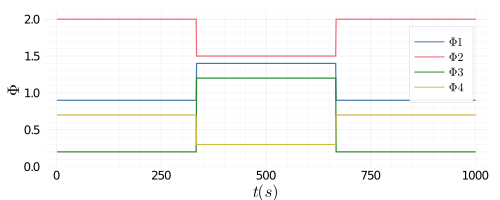

In [206]:
if var_flux == "var"
    const ATH_Flux = [0.9 2.0 0.2 0.7; 
                      1.4 1.5 1.2 0.3;
                      0.9 2.0 0.2 0.7];
end

# Flux constant
if var_flux == "cst"
    const ATH_Flux = [0.9 0.8 1.7 0.5; 
                      0.9 0.8 1.7 0.5;
                      0.9 0.8 1.7 0.5];
end

const e_0 = 1;

# debug
println("dt*N_T : ",dt*N_T)
#

# Flux definiton *******************************************
function phi(i,t)::Float64
    if flux == "Ath"
        species_flux = ATH_Flux[:,i]
        if t <= (dt*N_T)/3
            return species_flux[1]
        elseif t <= 2*(dt*N_T)/3
            return species_flux[2]
        else 
            return species_flux[3]
        end
    end
    if flux == "no"
        return 0
    end
end

# Flux vector ***********************************************
function Phi(i)::Array{Float64}
    return [ phi(i,k*dt)/ ep(k)  for k in 1:N_T]
end

# Sum of flux as derivative of thickness *********************
function ep(n)::Float64
    som = 0.0
    for k = 1:num_species
        som += phi(k,n*dt)
    end
    return som
end

# Thickness **************************************************
function e(n)::Float64
    sum = e_0
    for k = 1:n
        sum += dt*ep(k)
    end
    return sum
end

## Plots --------------------------------------------------------------------------
times = [k*dt for k in 1:N_T]
p1 = plot(times,[phi(1,k) for k in times],ylims=(0,2.1),label=L"\Phi 1",xlabel=L"t(s)",ylabel=L"\Phi")
p2 = plot!(p1,times,[phi(2,k) for k in times],ylims=(0,2.1),label=L"\Phi 2")
p3 = plot!(p2,times,[phi(3,k) for k in times],ylims=(0,2.1),label=L"\Phi 3")

p_phi = plot!(p3,times,[phi(4,k) for k in times],ylims=(0,2.1),label=L"\Phi 4")
p_d = plot(times,[ep(k) for k=1:N_T],label="de/dt",mark=:dot)
p_e = plot(times,[e(k) for k=1:N_T],label="e(t)")

if saving == true
    savefig(p_phi,string("./Pictures/",adress,"/Flux.png"))
end

plot(p_phi,size=(500,200))

In [207]:
"""Right BC ( x = 1 ): Need to invert the system B(v_{Nd})*v_{Nd+1/2} = e(n)Phi(n)
"""
# Compute B
function B(v,dx,e_,ep_)
    #println("Shape of v : ",size(v))
    out = zeros(num_species,num_species)
    #println(" === Begin debug ===")
    @inbounds for i=1:num_species
        @inbounds for j = 1:num_species
            out[i,j] += - (i != j)*(2/dx)*K[i,j]*v[i] + (i==j)*e_*ep_
            @inbounds for k = 1:num_species
                out[i,j] += (i==j)*(2/dx)*K[i,k]*v[k] 
            end
            #println("v : ",v)
            #println("out : "out[i,j])
        end
    end
    return out
end

# Compute V, vector of size (num_species, 1), representing right BC 
function v_RBC(v,dx,e_,ep_,Phi)
    V = B(v,dx,e_,ep_)    
    Invv = inv(V)
    out = ( Invv )* (e_*Phi )
    return out
end

v_RBC (generic function with 1 method)

In [208]:
# Definition of half points (i.e. points between two cells in 1D) ******************************
function log_mean(x, y; err=1e-14)
    if min(x, y) <= err
        return 0.0
    elseif abs(x-y) > err*y
        return (x - y) / (log(x) - log(y))
    else
        return (x + y) / 2
    end
end


function log_mean_left(U, i)
    if i % num_cells == 1 # Which means i is at Left BC at x = 0
        return U[i]
    end
    return log_mean(U[i - 1], U[i])
end

function log_mean_right(U, i,dx,e_,ep_,Phi)
    
    if i % num_cells == 0 # Which means i is at Right BC at x = 1
        if flux == "no"
            return U[i]
        end    
        N = length(U)
        if typeof(U[num_cells]) != Float64 # which means it is a FwdDiff dual type, which will be due to FwdDiff in nlSolve
            v = [ U[num_cells].value U[2*num_cells].value U[3*num_cells].value U[4*num_cells].value ]'
        end
        if typeof(U[num_cells]) == Float64 # which means the FwdDiff is done
            v = [ U[num_cells] U[2*num_cells] U[3*num_cells] U[4*num_cells] ]'
        end
        v_r = v_RBC(v,dx,e_,ep_,Phi)
        
        # Debug, to see what is going on
        #println("v[1]: ",v[1])
        #println("v_r : ",v_r)
        #println(" i = ",i)
        #println(" i ÷ num_cells = ",i ÷ num_cells)
        return v_r[i ÷ num_cells]
    end
    return log_mean(U[i + 1], U[i])
end


# Discrete derivative : /!\ Pay attention to the signs, this is design to keep constant sign as much as possible in the scheme
function left_deriv_space(U, i, dx)
    if i % num_cells == 1 # Which means i is at Left BC at x = 0
        return 0.0
    end
    return (U[i - 1] - U[i])/dx
end
    
function right_deriv_space(U, i,dx,e_,ep_,Phi)
    if i % num_cells == 0 # Which means i is at Right BC at x = 1
        if flux == "no"
            return 0.0
        end
        vr = log_mean_right(U, i,dx,e_,ep_,Phi)
        return 2*(vr - U[i])/dx
    end
    return (U[i + 1] - U[i])/dx
end

right_deriv_space (generic function with 1 method)

In [209]:
# Normed Mean

function get_index(i)::Int8
    if i <= num_cells
        return 1 
    end
    if i > num_cells && i <= 2*num_cells
        return 2 
    end
    if i > 2*num_cells && i <= 3*num_cells
        return 3 
    end
    if i > 3*num_cells && i <= 4*num_cells
        return 4
    end
end

# Arithmetic mean 


function arith_mean(x,y)
    return (x + y) / 2
end

function arith_mean_left(U, i)
    if i % num_cells == 1 # Which means i is at Left BC at x = 0
        return U[i]
    end
    return arith_mean(U[i - 1], U[i])
end

function arith_mean_right(U, i,dx,e_,ep_,Phi)
    
    if i % num_cells == 0 # Which means i is at Right BC at x = 1
        if flux == "no"
            return U[i]
        end    
        N = length(U)
        if typeof(U[num_cells]) != Float64 # which means it is a FwdDiff dual type, which will be due to FwdDiff in nlSolve
            v = [ U[num_cells].value U[2*num_cells].value U[3*num_cells].value U[4*num_cells].value ]'
        end
        if typeof(U[num_cells]) == Float64 # which means the FwdDiff is done
            v = [ U[num_cells] U[2*num_cells] U[3*num_cells] U[4*num_cells] ]'
        end
        v_r = v_RBC(v,dx,e_,ep_,Phi)
        
        # Debug, to see what is going on
        #println("v[1]: ",v[1])
        #println("v_r : ",v_r)
        #println(" i = ",i)
        #println(" i ÷ num_cells = ",i ÷ num_cells)
        return v_r[i ÷ num_cells]
    end
    return arith_mean(U[i + 1], U[i])
end


arith_mean_right (generic function with 1 method)

In [210]:
#print([a % num_cells for a = 1:200])

## Conservation Law : Main ------------------------------------

In [211]:
# Replace log mean with cell value on drift terms : YES

function f!(F, U, Uold, num_species, num_cells, dx, dt, k, Kbar,e_,ep_,Phi)
    
    @inbounds for i = 1:num_species, p in 1:num_cells
        # Adapting index to 1D setup
        ind_i = (i - 1) * num_cells + p
        # Linear contributions ---------------------------------------
        inflow = -(k/(e_)^2) * left_deriv_space(U, ind_i, dx) + (ep_/e_)*( x_left[p]*arith_mean_left(U,ind_i) + dx*Uold[ind_i])
        outflow = -(k/(e_)^2) * right_deriv_space(U, ind_i, dx, e_,ep_,Phi) - (ep_/e_)*x_right[p]*arith_mean_right(U,ind_i,dx,e_,ep_,Phi)

        # Non-linear contributions ------------------------------------
        @inbounds for j = 1:num_species
            ind_j = (j - 1) * num_cells + p
            
            inflow += (j != i)* (1/e_^2) * -Kbar[i,j] * (log_mean_left(U, ind_j) * left_deriv_space(U, ind_i, dx)
                                              - log_mean_left(U, ind_i) * left_deriv_space(U, ind_j, dx))
            
            outflow += (j != i)* (1/e_^2) * -Kbar[i,j] * (log_mean_right(U, ind_j,dx,e_,ep_,Phi) * right_deriv_space(U, ind_i, dx,e_,ep_,Phi)
                                              - log_mean_right(U, ind_i,dx,e_,ep_,Phi) * right_deriv_space(U, ind_j, dx,e_,ep_,Phi) )
        end
        
        # Flux equilibrium ---------------------------------------------
        F[ind_i] = (U[ind_i] - Uold[ind_i])/dt + (inflow + outflow)/dx
    end 
end

f! (generic function with 1 method)

## Solver ===========================

In [212]:
"""  Auxilary functions for validation  """

# Check if sum across species is indeed 1 ------------------------------------------------------
function check_sum_1(U,tol)::Bool
    U1 = U[1:num_cells];
    U2 = U[num_cells + 1:2*num_cells];
    U3 = U[2*num_cells + 1:3*num_cells];
    U4 = U[3*num_cells + 1:4*num_cells];
    S = @. U1 + U2 + U3 + U4;
    @inbounds for i = 1:length(S)
        if abs(S[i] - 1) >= tol
            return false
        end
    end
    return true
end

function sum_(U)::Array{Float64}
    U1 = U[1:num_cells];
    U2 = U[num_cells + 1:2*num_cells];
    U3 = U[2*num_cells + 1:3*num_cells];
    U4 = U[3*num_cells + 1:4*num_cells];
    S = @. U1 + U2 + U3 + U4;
    return S
end

function max_sum(U)::Float64
    U1 = U[1:num_cells];
    U2 = U[num_cells + 1:2*num_cells];
    U3 = U[2*num_cells + 1:3*num_cells];
    U4 = U[3*num_cells + 1:4*num_cells];
    S = @. U1 + U2 + U3 + U4;
    max_ = -1.0
    @inbounds for i = 1:length(S)
        if S[i] >= max_
            max_ = S[i]
        end
    end
    return max_
end

# Plotting function -------------------------------------------------------------------
function draw(result;yinf=-0.1,ysup=1.1,location =string("./Pictures/",adress,"/mx_Final_Profile_200s.png"),w_length=window,w_heigth=window)
    U1 = result[1:num_cells];
    U2 = result[num_cells + 1:2*num_cells];
    U3 = result[2*num_cells + 1:3*num_cells];
    U4 = result[3*num_cells + 1:4*num_cells];

    p1 = plot(cells1D, U1, label="Concentration of species 1",mark=:dot, xlabel=L"x", ylabel=L"U",ylims = (yinf,ysup));
    p2 = plot!(p1,cells1D, U2, label="Concentration of species 2",mark=:dot, xlabel=L"x", ylabel=L"U");
    p3 = plot!(p2,cells1D, U3, label="Concentration of species 3",mark=:dot, xlabel=L"x", ylabel=L"U");
    p4 = plot!(p3,cells1D, U4, label="Concentration of species 4",mark=:dot, xlabel=L"x", ylabel=L"U");
    #p5 = plot(cells1D,U1+U2+U3+U4, label="Sum of all species",mark=:dot, xlabel=L"x", ylabel=L"U")

    #if saving == true
    #    savefig(p4,string("./Pictures/",adress,"/Final_Profile.png"))
    #end
    plot(p4,size = (w_length,w_heigth))
end

function draw_sum(result;w_length=window,w_heigth=window)
    U1 = result[1:num_cells];
    U2 = result[num_cells + 1:2*num_cells];
    U3 = result[2*num_cells + 1:3*num_cells];
    U4 = result[3*num_cells + 1:4*num_cells];

    p5 = plot(cells1D,U1+U2+U3+U4, label="Sum of all species",yaxis=:log,mark=:dot, xlabel=L"x", ylabel=L"U")

    if saving == true
        savefig(p5,string("./Pictures/",adress,"/Final_Profile_Sum.png"))
    end
    plot(p5,size = (w_length,w_heigth))
end
# Discrete entropy ----------------------------------------------------------------------
function discrete_entropy(U, Δx; err=1e-10)::Float64
    entropy = 0.0
    @inbounds for i = 1:length(U)
        if U[i] >= err
            entropy += Δx * U[i] * log(U[i]) 
        end
    end
    return entropy
 end

function discrete_entropy_bar(U, Δx,n; err=1e-10)::Float64
    entropy = 0.0
    @inbounds for i = 1:length(U)
        index = get_index(i)
        f = (phi(index,n*dt))/(ep(n))
        if U[i] >= err
            entropy += Δx * ( U[i] * log(U[i]) - f * log(f) - (log(f)+1)*( U[i] - f) )
        end
    end
    return entropy
 end

# Discrete mass ---------------------------------------------------------------------
function mass(U,specie,dx,n)::Float64
    s = 0
    @inbounds for i = 1:num_cells
        ind_i = (specie - 1) * num_cells + i
        s += U[ind_i] * dx * e(n)
    end
    return s
end

mass (generic function with 1 method)

In [213]:
function right_BC_sum(U)::Float64
    sum = 0.0
    @inbounds for k = 1:num_species
        sum += U[k*num_cells]
    end
    return sum
end

# Csizar Kullback UB : 2\ol{E}^n + 2 \sum_{i=1}^N (\ol{v_i}^n ln (f_i / \ol{v_i}^n))
function UpperBound_CK(U,dx,f)::Float64
    m = mass_mean(U,dx)
    S = 0.0
    @inbounds for i = 1 : num_species
        S += m[i] * log( f[i] / m[i] )
    end
    return S
end


UpperBound_CK (generic function with 1 method)

In [214]:

""" *******************************  SOLVER ****************************************** """

function do_simulation(final_time, U0, num_species, 
        num_cells, dx, dt, k, Kbar
        ;nltol=1e-8,nliter=1000,show_trace_=false,start_n = 1,epoch = 1)
    println(" **** BEGIN SOLVER **** /////////////////////////////////////")
    println(" --  Final Time  : ",final_time)
    println(" --  (dx , dt )  : ", dx ," , ",dt)
    println(" --  Newton Tol  : ",nltol)
    println(" --  Iteration   : < ",nliter +1)
    println(" --  Show Trace : ",show_trace_)
    println(" --  Initial max sum - 1 : ",max_sum(U0) - 1)
    
    # Initialization
    current_time = dt
    current_n = start_n
    Uold = U0
    if flux == "no"
        f = [0.0 for k = 1:num_species]
    end
    if flux == "Ath"
        f = [(phi(k,dt))/ep(1) for k=1:num_species]
    end
    
    # Entropy
    entropies = Vector{Float64}()
    if var_flux == "var"
        push!(entropies, discrete_entropy(Uold, dx))
    end
    if var_flux == "cst"
        push!(entropies, discrete_entropy_bar(Uold, dx,current_n - 1))
    end
    
    
    # Mass (initialisation at n = 0)
    mass_1 = Vector{Float64}()
    push!(mass_1,mass(Uold,1,dx,current_n-1))
    mass_2 = Vector{Float64}()
    push!(mass_2,mass(Uold,2,dx,current_n-1))
    mass_3 = Vector{Float64}()
    push!(mass_3,mass(Uold,3,dx,current_n-1))
    mass_4 = Vector{Float64}()
    push!(mass_4,mass(Uold,4,dx,current_n-1))
    
    # Non convergence
    non_cvg = Vector{Int64}()
    
    # Loop
    while current_time <= final_time
        e_ = e(current_n)
        ep_ = ep(current_n)
        Phi = [phi(1,current_n*dt) phi(2,current_n*dt) phi(3,current_n*dt) phi(4,current_n*dt)]'
        #println("\n ********  \n Step ",current_time," \n *************")
        # Time stamp
        t1 = time_ns()
        Utmp = Uold # for type stability
        g!(F, U) = f!(F, U, Utmp, num_species, num_cells, dx, dt, k, Kbar,e_,ep_,Phi)
        solver = nlsolve(g!, Utmp, autodiff=:forward,ftol = nltol,iterations = nliter
            ,method = :trust_region,show_trace=show_trace_)
        Uold = solver.zero
        has_converged = converged(solver)
        # Updating quantities
        
        if var_flux == "var"
            push!(entropies, discrete_entropy(Uold, dx))
        end
        if var_flux == "cst"
            push!(entropies, discrete_entropy_bar(Uold, dx,current_n))
        end
        
        push!(mass_1,mass(Uold,1,dx,current_n))
        push!(mass_2,mass(Uold,2,dx,current_n))
        push!(mass_3,mass(Uold,3,dx,current_n))
        push!(mass_4,mass(Uold,4,dx,current_n))
        
        # Outputs
        # Time stamp 2
        t2 = time_ns()
        delta_t12 = (t2 - t1)/(1.0e9)
        #print("current_n % epoch : ",current_n % epoch)
        if current_n % epoch == 0
            println("\n ---- Step : ",current_n ," / ", floor(final_time / dt)," ----")
            println(" - Time : ",delta_t12," seconds")
            println(" - Current max sum - 1 : ",max_sum(Uold) - 1)
            println(" - Convergence : ",has_converged)
            println(" ---- ---- -----" )
        end
        current_time += dt
        current_n += 1
        if has_converged == false
            push!(non_cvg,current_n)
        end
        
    end
    println("Steps n where non convergence : ",non_cvg)
    mass_   = mass_1,mass_2,mass_3,mass_4
    return Uold, entropies,mass_
end

do_simulation (generic function with 1 method)

# Solver - Running

In [215]:
start = time_ns() #
result, entropies,mass_ = do_simulation(T, U0, num_species, num_cells, dx,
    dt, k, Kbar,nltol=1e-8,nliter=10000,show_trace_ = true,epoch = 1);
end_ = time_ns()
delta_t = (end_ - start)/(1.0e9)
print(" Done in ",delta_t," s")

 **** BEGIN SOLVER **** /////////////////////////////////////
 --  Final Time  : 1000
 --  (dx , dt )  : 0.0005 , 1.0
 --  Newton Tol  : 1.0e-8
 --  Iteration   : < 10001
 --  Show Trace : true
 --  Initial max sum - 1 : 2.220446049250313e-16
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.666039e+02              NaN
     1     2.940826e+02     6.742863e+00
     2     2.767290e+02     5.083338e-01
     3     2.604090e+02     4.797647e-01
     4     2.450603e+02     4.528556e-01
     5     2.306240e+02     4.275164e-01
     6     2.170798e+02     4.036512e-01
     7     2.066529e+02     3.811705e-01
     8     1.967268e+02     3.599907e-01
     9     1.872775e+02     3.400332e-01
    10     1.782821e+02     3.212245e-01
    11     1.697187e+02     3.034958e-01
    12     1.615667e+02     2.867826e-01
    13     1.538062e+02     2.710243e-01
    14     1.464185e+02     2.561642e-01
    15     1.393857e+02     2.421492e-01
    16     1.326906e+

   192     6.599815e+00     9.485202e-05
   193     6.568828e+00     9.489926e-05
   194     6.571639e+00     9.487032e-05
   195     6.541163e+00     9.491606e-05
   196     6.543844e+00     9.488791e-05
   197     6.513865e+00     9.493222e-05
   198     6.516421e+00     9.490485e-05
   199     6.486926e+00     9.494779e-05
   200     6.489364e+00     9.492116e-05
   201     6.460339e+00     9.496279e-05
   202     6.462664e+00     9.493687e-05
   203     6.434096e+00     9.497726e-05
   204     6.436313e+00     9.495202e-05
   205     6.408190e+00     9.499120e-05
   206     6.410305e+00     9.496672e-05
   207     6.382616e+00     9.500480e-05
   208     6.384633e+00     9.498072e-05
   209     6.357365e+00     9.501766e-05
   210     6.359289e+00     9.499431e-05
   211     6.332433e+00     9.503020e-05
   212     6.334267e+00     9.500744e-05
   213     6.307811e+00     9.504232e-05
   214     6.309560e+00     9.502012e-05
   215     6.283494e+00     9.505403e-05
   216     6.285

   392     5.135428e+00     9.542244e-05
   393     5.138394e+00     9.542876e-05
   394     5.127050e+00     9.542372e-05
   395     5.129977e+00     9.542995e-05
   396     5.118710e+00     9.542496e-05
   397     5.121600e+00     9.543112e-05
   398     5.110411e+00     9.542619e-05
   399     5.113264e+00     9.543226e-05
   400     5.102151e+00     9.542738e-05
   401     5.104968e+00     9.543338e-05
   402     5.093929e+00     9.542855e-05
   403     5.096711e+00     9.543447e-05
   404     5.085747e+00     9.542970e-05
   405     5.088494e+00     9.543554e-05
   406     5.077602e+00     9.543082e-05
   407     5.080316e+00     9.543658e-05
   408     5.069496e+00     9.543191e-05
   409     5.072176e+00     9.543760e-05
   410     5.061428e+00     9.543298e-05
   411     5.064075e+00     9.543860e-05
   412     5.053398e+00     9.543403e-05
   413     5.056012e+00     9.543958e-05
   414     5.045405e+00     9.543506e-05
   415     5.047987e+00     9.544054e-05
   416     5.037

   592     4.456478e+00     9.547087e-05
   593     4.457490e+00     9.547304e-05
   594     4.450978e+00     9.547090e-05
   595     4.451981e+00     9.547304e-05
   596     4.445498e+00     9.547135e-05
   597     4.446492e+00     9.547305e-05
   598     4.440039e+00     9.547094e-05
   599     4.441023e+00     9.547305e-05
   600     4.434599e+00     9.547096e-05
   601     4.435574e+00     9.547305e-05
   602     4.429178e+00     9.547097e-05
   603     4.430145e+00     9.547304e-05
   604     4.423778e+00     9.547097e-05
   605     4.424735e+00     9.547302e-05
   606     4.418396e+00     9.547097e-05
   607     4.419345e+00     9.547301e-05
   608     4.413034e+00     9.547097e-05
   609     4.413974e+00     9.547299e-05
   610     4.407692e+00     9.547096e-05
   611     4.408623e+00     9.547296e-05
   612     4.402368e+00     9.547095e-05
   613     4.403291e+00     9.547293e-05
   614     4.397064e+00     9.547093e-05
   615     4.397978e+00     9.547290e-05
   616     4.391

   792     4.001534e+00     9.545742e-05
   793     3.996805e+00     9.545841e-05
   794     3.998304e+00     9.545717e-05
   795     3.993590e+00     9.545816e-05
   796     3.995081e+00     9.545692e-05
   797     3.990382e+00     9.545791e-05
   798     3.991865e+00     9.545668e-05
   799     3.987180e+00     9.545765e-05
   800     3.988654e+00     9.545643e-05
   801     3.983984e+00     9.545740e-05
   802     3.985450e+00     9.545618e-05
   803     3.980795e+00     9.545714e-05
   804     3.982252e+00     9.545593e-05
   805     3.977612e+00     9.545688e-05
   806     3.979060e+00     9.545567e-05
   807     3.974434e+00     9.545662e-05
   808     3.975875e+00     9.545542e-05
   809     3.971263e+00     9.545636e-05
   810     3.972696e+00     9.545516e-05
   811     3.968098e+00     9.545610e-05
   812     3.969523e+00     9.545491e-05
   813     3.964939e+00     9.545584e-05
   814     3.966356e+00     9.545465e-05
   815     3.961786e+00     9.545557e-05
   816     3.963

   992     3.707078e+00     9.542794e-05
   993     3.703517e+00     9.542845e-05
   994     3.704397e+00     9.542760e-05
   995     3.700844e+00     9.542812e-05
   996     3.701720e+00     9.542727e-05
   997     3.698176e+00     9.542778e-05
   998     3.699047e+00     9.542694e-05
   999     3.695512e+00     9.542745e-05
  1000     3.696380e+00     9.542661e-05
  1001     3.692854e+00     9.542711e-05
  1002     3.693717e+00     9.542628e-05
  1003     3.690200e+00     9.542678e-05
  1004     3.691058e+00     9.542594e-05
  1005     3.687550e+00     9.542644e-05
  1006     3.688405e+00     9.542561e-05
  1007     3.684905e+00     9.542610e-05
  1008     3.685755e+00     9.542527e-05
  1009     3.682264e+00     9.542577e-05
  1010     3.683111e+00     9.542494e-05
  1011     3.679629e+00     9.542543e-05
  1012     3.680471e+00     9.542460e-05
  1013     3.676997e+00     9.542509e-05
  1014     3.677835e+00     9.542427e-05
  1015     3.674370e+00     9.542475e-05
  1016     3.675

  1192     3.459970e+00     9.539230e-05
  1193     3.457143e+00     9.539323e-05
  1194     3.457694e+00     9.539259e-05
  1195     3.454873e+00     9.539286e-05
  1196     3.455421e+00     9.539222e-05
  1197     3.452606e+00     9.539250e-05
  1198     3.453151e+00     9.539186e-05
  1199     3.450342e+00     9.539213e-05
  1200     3.450885e+00     9.539149e-05
  1201     3.448082e+00     9.539177e-05
  1202     3.448623e+00     9.539113e-05
  1203     3.445825e+00     9.539140e-05
  1204     3.446364e+00     9.539076e-05
  1205     3.443572e+00     9.539103e-05
  1206     3.444108e+00     9.539040e-05
  1207     3.441322e+00     9.539067e-05
  1208     3.441855e+00     9.539003e-05
  1209     3.439075e+00     9.539030e-05
  1210     3.439607e+00     9.538967e-05
  1211     3.436832e+00     9.538993e-05
  1212     3.437361e+00     9.538930e-05
  1213     3.434593e+00     9.538956e-05
  1214     3.435119e+00     9.538894e-05
  1215     3.432356e+00     9.538920e-05
  1216     3.432

  1392     3.248078e+00     9.535578e-05
  1393     3.245753e+00     9.535593e-05
  1394     3.246106e+00     9.535540e-05
  1395     3.243785e+00     9.535555e-05
  1396     3.244136e+00     9.535503e-05
  1397     3.241820e+00     9.535517e-05
  1398     3.242169e+00     9.535465e-05
  1399     3.239857e+00     9.535479e-05
  1400     3.240205e+00     9.535427e-05
  1401     3.237897e+00     9.535441e-05
  1402     3.238243e+00     9.535389e-05
  1403     3.235939e+00     9.535403e-05
  1404     3.236284e+00     9.535351e-05
  1405     3.233984e+00     9.535365e-05
  1406     3.234328e+00     9.535314e-05
  1407     3.232032e+00     9.535327e-05
  1408     3.232374e+00     9.535276e-05
  1409     3.230082e+00     9.535289e-05
  1410     3.230422e+00     9.535213e-05
  1411     3.228135e+00     9.535252e-05
  1412     3.228474e+00     9.535200e-05
  1413     3.226191e+00     9.535213e-05
  1414     3.226528e+00     9.535162e-05
  1415     3.224249e+00     9.535176e-05
  1416     3.224

  1592     3.062925e+00     9.531765e-05
  1593     3.060963e+00     9.531771e-05
  1594     3.061187e+00     9.531727e-05
  1595     3.059228e+00     9.531733e-05
  1596     3.059451e+00     9.531688e-05
  1597     3.057495e+00     9.531694e-05
  1598     3.057717e+00     9.531650e-05
  1599     3.055763e+00     9.531656e-05
  1600     3.055985e+00     9.531611e-05
  1601     3.054034e+00     9.531617e-05
  1602     3.054255e+00     9.531573e-05
  1603     3.052307e+00     9.531578e-05
  1604     3.052527e+00     9.531534e-05
  1605     3.050583e+00     9.531540e-05
  1606     3.050801e+00     9.531496e-05
  1607     3.048860e+00     9.531501e-05
  1608     3.049077e+00     9.531458e-05
  1609     3.047139e+00     9.531463e-05
  1610     3.047355e+00     9.531419e-05
  1611     3.045420e+00     9.531424e-05
  1612     3.045635e+00     9.531381e-05
  1613     3.043703e+00     9.531386e-05
  1614     3.043917e+00     9.531342e-05
  1615     3.041988e+00     9.531347e-05
  1616     3.042

  1792     2.898563e+00     9.527903e-05
  1793     2.896872e+00     9.527903e-05
  1794     2.897008e+00     9.527864e-05
  1795     2.895320e+00     9.527864e-05
  1796     2.895456e+00     9.527825e-05
  1797     2.893770e+00     9.527825e-05
  1798     2.893905e+00     9.527786e-05
  1799     2.892221e+00     9.527786e-05
  1800     2.892356e+00     9.527748e-05
  1801     2.890674e+00     9.527748e-05
  1802     2.890808e+00     9.527709e-05
  1803     2.889129e+00     9.527709e-05
  1804     2.889262e+00     9.527670e-05
  1805     2.887586e+00     9.527670e-05
  1806     2.887718e+00     9.527631e-05
  1807     2.886043e+00     9.527631e-05
  1808     2.886175e+00     9.527592e-05
  1809     2.884503e+00     9.527592e-05
  1810     2.884634e+00     9.527553e-05
  1811     2.882964e+00     9.527553e-05
  1812     2.883094e+00     9.527515e-05
  1813     2.881427e+00     9.527514e-05
  1814     2.881556e+00     9.527476e-05
  1815     2.879891e+00     9.527476e-05
  1816     2.880

  1992     2.750716e+00     9.524008e-05
  1993     2.749236e+00     9.524003e-05
  1994     2.749309e+00     9.523968e-05
  1995     2.747831e+00     9.523965e-05
  1996     2.747904e+00     9.523929e-05
  1997     2.746428e+00     9.523926e-05
  1998     2.746500e+00     9.523890e-05
  1999     2.745026e+00     9.523886e-05
  2000     2.745098e+00     9.523851e-05
  2001     2.743625e+00     9.523847e-05
  2002     2.743697e+00     9.523812e-05
  2003     2.742226e+00     9.523808e-05
  2004     2.742297e+00     9.523773e-05
  2005     2.740828e+00     9.523769e-05
  2006     2.740898e+00     9.523734e-05
  2007     2.739431e+00     9.523730e-05
  2008     2.739501e+00     9.523695e-05
  2009     2.738036e+00     9.523691e-05
  2010     2.738105e+00     9.523656e-05
  2011     2.736642e+00     9.523652e-05
  2012     2.736711e+00     9.523616e-05
  2013     2.735249e+00     9.523612e-05
  2014     2.735317e+00     9.523577e-05
  2015     2.733857e+00     9.523573e-05
  2016     2.733

  2192     2.616236e+00     9.520082e-05
  2193     2.614923e+00     9.520075e-05
  2194     2.614951e+00     9.520043e-05
  2195     2.613639e+00     9.520036e-05
  2196     2.613666e+00     9.520003e-05
  2197     2.612356e+00     9.519996e-05
  2198     2.612382e+00     9.519964e-05
  2199     2.611074e+00     9.519957e-05
  2200     2.611100e+00     9.519924e-05
  2201     2.609793e+00     9.519918e-05
  2202     2.609818e+00     9.519885e-05
  2203     2.608513e+00     9.519878e-05
  2204     2.608538e+00     9.519853e-05
  2205     2.607234e+00     9.519839e-05
  2206     2.607258e+00     9.519806e-05
  2207     2.605956e+00     9.519799e-05
  2208     2.605980e+00     9.519767e-05
  2209     2.604679e+00     9.519760e-05
  2210     2.604703e+00     9.519727e-05
  2211     2.603403e+00     9.519720e-05
  2212     2.603427e+00     9.519688e-05
  2213     2.602129e+00     9.519681e-05
  2214     2.602152e+00     9.519648e-05
  2215     2.600855e+00     9.519641e-05
  2216     2.600

InterruptException: InterruptException:

# Saving & Loading

In [216]:
print(adress)

dt_1.0/1D_Flux_Ari__dt1.0_dx0.0005

In [217]:
# Save Data using JLD
save(string("./Data_Cvg/",adress,".jld"),"result",result,
                                    "entropies",entropies,
                                    "mass_",[mass_[1],mass_[2],mass_[3],mass_[4]])
                                    

In [195]:
# Loading data
result    = load(string("./Data_Cvg/",adress,".jld"),"result")
entropies = load(string("./Data_Cvg/",adress,".jld"),"entropies")
mass_    = load(string("./Data_Cvg/",adress,".jld"),"mass_");

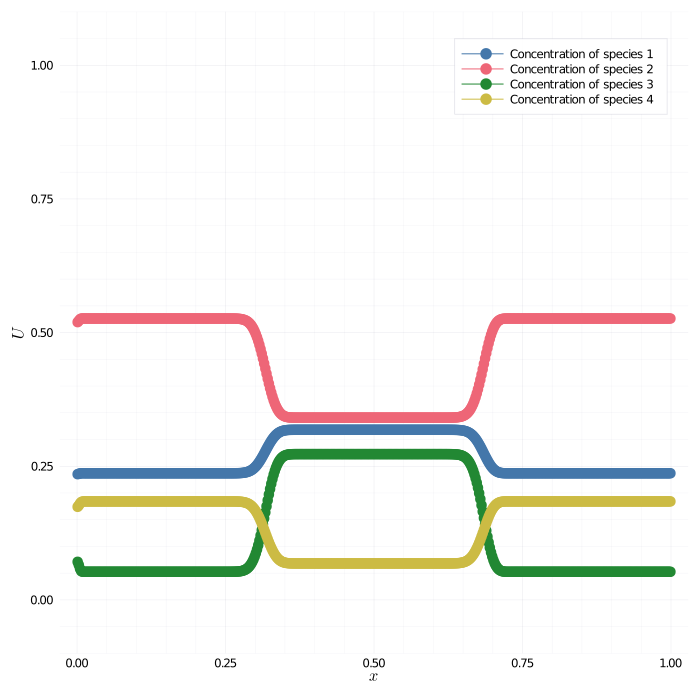

In [193]:
draw(result)

In [ ]:
print([phi(1,1*dt) phi(2,1*dt) phi(3,1*dt) phi(4,1*dt)]')

In [ ]:

function draw_save(result;yinf=-0.1,ysup=1.1,location =string("./Pictures/",adress,"/mx_Final_Profile_200s.png"),w_length=window,w_heigth=window)
    U1 = result[1:num_cells];
    U2 = result[num_cells + 1:2*num_cells];
    U3 = result[2*num_cells + 1:3*num_cells];
    U4 = result[3*num_cells + 1:4*num_cells];

    p1 = plot(cells1D, U1, label="Concentration of species 1",mark=:dot, xlabel=L"x", ylabel=L"U",ylims = (yinf,ysup));
    p2 = plot!(p1,cells1D, U2, label="Concentration of species 2",mark=:dot, xlabel=L"x", ylabel=L"U");
    p3 = plot!(p2,cells1D, U3, label="Concentration of species 3",mark=:dot, xlabel=L"x", ylabel=L"U");
    p4 = plot!(p3,cells1D, U4, label="Concentration of species 4",mark=:dot, xlabel=L"x", ylabel=L"U");
    #p5 = plot(cells1D,U1+U2+U3+U4, label="Sum of all species",mark=:dot, xlabel=L"x", ylabel=L"U")

    savefig(p4,string("./Pictures/mixed_drift_cst/Final_Profile.png"))
    plot(p4,size = (w_length,w_heigth))
end

function draw_sum_save(result;w_length=window,w_heigth=window)
    U1 = result[1:num_cells];
    U2 = result[num_cells + 1:2*num_cells];
    U3 = result[2*num_cells + 1:3*num_cells];
    U4 = result[3*num_cells + 1:4*num_cells];

    p5 = plot(cells1D,U1+U2+U3+U4, label="Sum of all species",yaxis=:log,mark=:dot, xlabel=L"x", ylabel=L"U")

    savefig(p5,string("./Pictures/mixed_drift_cst/Final_Profile_sum.png"))
    plot(p5,size = (w_length,w_heigth))
end

draw_sum_save(result[length(entropies)])

# Mass checking

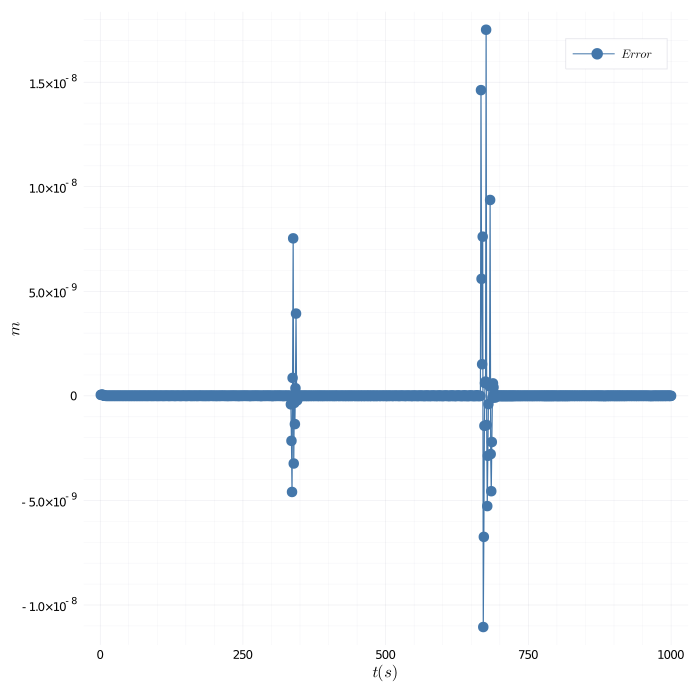

In [23]:
## Check Theoretical behaviour of massess ------------------------------------
x_axis = 1:length(mass_[1]) - 1
x_index = @. x_axis + 1

showing = "plot" # print of plot

function validate_mass(index,dt)
    if index == 1
        diff_mass = [ mass_[1][n] - mass_[1][n-1] for n in x_index ]
        Phi = [phi(1,n*dt) for n in x_axis] 
        end
    if index == 2
        diff_mass = [ mass_2[n] - mass_2[n-1] for n in x_index ]
        Phi = [phi(2,n*dt) for n in x_axis]
        end
    if index == 3
        diff_mass = [ mass_3[n] - mass_3[n-1] for n in x_index ]
        Phi = [phi(3,n*dt) for n in x_axis]
        end
    if index == 4
        diff_mass = [ mass_4[n] - mass_4[n-1] for n in x_index ]
        Phi = [phi(4,n*dt) for n in x_axis]
        end
    if showing == "print"
        println(" Mass ",index," differences : \n",diff_mass)
        println(" (Flux ",index,") x dt  : \n",dt*Phi)
        println(" Error : ",diff_mass - dt*Phi,"\n")
    end
    if showing == "plot"
        times = [k*dt for k =  1:length(mass_[1])-1]
        p1 = plot(times,diff_mass,label = string(L"Mass_^n - Mass^{n-1}","species ",index),
            mark=:dot,xlabel=L"t(s)", ylabel=L"m")
        p2 = plot(times,dt*Phi,label = L"\Delta t \Phi",
            mark=:dot,xlabel=L"t(s)", ylabel=L"m")
        p3 = plot(times,diff_mass - dt*Phi,label = L"Error",xlabel=L"t(s)", ylabel=L"m",mark=:dot)
        #plot(p1,p2,p3,layout=(3,1))
        plot(p3,size=(window,window))
        #savefig(p3,"./Pictures/mixed_drift_cst/Mass_error.png")
    end
        
end
validate_mass(1,dt)

## Verification - L1 related

In [ ]:
## Check L1 error
xxis = :log
times = [i*dt for i=1:length(entropies)]
p1 = plot(times,L1_err_[1],xaxis=xxis,yaxis=:log,label = L"L^1(specie~ 1) ~ error"
    ,minorgrid=true)
p2 = plot!(p1,times,L1_err_[2],xaxis=xxis,yaxis=:log,label = L"L^1(specie~ 2) ~ error")
p3 = plot!(p2,times,L1_err_[3],xaxis=xxis,yaxis=:log,label = L"L^1(specie~ 3) ~ error")
p4 = plot!(p3,times,L1_err_[4],xaxis=xxis,yaxis=:log,label = L"L^1(specie~ 4) ~ error")
plot(p4)
savefig(p4,"./Pictures/mixed_drift_cst/L1_error.png")

In [ ]:
# Visualizing profile error
function draw_error(vec)
    if flux == "no"
        f = [0.0 for k = 1:num_species]
    end
    if flux == "Ath"
        f = [(phi(k,dt))/ep(1) for k=1:num_species]
    end
    U1 = vec[1:num_cells];
    U2 = vec[num_cells + 1:2*num_cells];
    U3 = vec[2*num_cells + 1:3*num_cells];
    U4 = vec[3*num_cells + 1:4*num_cells];

    p1 = plot(cells1D,U1 .- f[1], label="Error on species 1",mark=:dot);
    p2 = plot!(p1,cells1D,U2 .- f[2], label="Error on species 2");
    p3 = plot!(p2,cells1D,U3 .- f[3], label="Error on species 3");
    p4 = plot!(p3,cells1D,U4 .- f[4], label="Error on species 4",mark=:dot);
    
    plot(p4)
    savefig(p4,"./Pictures/mixed_drift_cst/Error_from_flux.png")
end


In [ ]:
indx = length(entropies)
println("L1_err[4][",indx,"] : ",L1_err_[4][indx])
draw_error(result[indx])

In [ ]:
# Visualize error to the mean value
times = [i*dt for i=1:length(entropies)]
p1 = plot(times,STD_[1],xaxis=:log,yaxis=:log,label = L"Mean(specie_1) ~ error")
p2 = plot!(p1,times,STD_[2],xaxis=:log,yaxis=:log,label = L"Mean(specie_2) ~ error")
p3 = plot!(p2,times,STD_[3],xaxis=:log,yaxis=:log,label = L"Mean(specie_3) ~ error")
p4 = plot!(p3,times,STD_[4],xaxis=:log,yaxis=:log,label = L"Mean(specie_4) ~ error")
plot(p4)

In [ ]:
# Csizar Kullback first ineq
p11 = plot(times,STD_[1].^2     ,xaxis = :log, yaxis = :log,label = L"STD_1") 
p12 = plot(times,STD_[2].^2,xaxis = :log, yaxis = :log,label = L"STD_2") 
p13 = plot(times,STD_[3].^2,xaxis = :log, yaxis = :log,label = L"STD_3") 
p14 = plot(times,STD_[4].^2,xaxis = :log, yaxis = :log,label = L"STD_4") 

p21 = plot!(p11,times,CK_[1]     ,xaxis = :log, yaxis = :log,label = L"CK_1") 
p22 = plot!(p12,times,CK_[2],xaxis = :log, yaxis = :log,label = L"CK_2") 
p23 = plot!(p13,times,CK_[3],xaxis = :log, yaxis = :log,label = L"CK_3") 
p24 = plot!(p14,times,CK_[4],xaxis = :log, yaxis = :log,label = L"CK_4") 

p = plot(p21,p22,p23,p24,layout = (1,4),size = (800,500))

savefig(p,"./Pictures/mixed_drift_cst/Csizar_Kullback.png")

In [ ]:
# Csizar Kullback second ineq
print(length(UB))
STD = @. STD_[1]^2 + STD_[2]^2 + STD_[3]^2 + STD_[4]^2 

UpperBound = [2*entropies[n] + 2*UB[n] for n = 1:length(entropies)]

p1 = plot(times,STD,xaxis = :log, yaxis = :log,label = "STD")
p2 = plot!(p1,times,UpperBound,xaxis = :log, yaxis = :log,label = "UpperBound")
plot(p2)

In [ ]:
# Entropies

p1 = plot(times, entropies,xaxis = :log, yaxis = :log,label = L"\overline{E}" )
p2 = plot!(p1,times, [(entropies[1]*e_0)/(e_0+n*dt*ep(1)) for n=0:length(entropies)-1],label=L"E^0 e_0/(e_0 + ndtV)")
plot(p2)
savefig(p2,"./Pictures/mixed_drift_cst/Entropy_rate.png")

In [ ]:
# Brutal inequality
print(length(L1_err_[1]))
f = [(phi(k,dt))/ep(1) for k = 1:num_species]
m0 = mass_mean(U0,dx)
m0_fi = abs(m0[1] - f[1])+abs(m0[2] - f[2])+abs(m0[3] - f[3])+abs(m0[4] - f[4])

C = minimum([f[1],f[2],f[3],f[4],m0[1],m0[2],m0[3],m0[4]])

L1_err2 = @. L1_err_[1]^2 + L1_err_[2]^2 + L1_err_[3]^2 + L1_err_[4]^2 
Above = [ 2*(e_0/(e_0 + n*dt*ep(1)))*( entropies[1] + m0_fi/C ) + 
    num_species*(m0_fi*e_0/(e_0 + n*dt*ep(1)))^2 for n = 0:length(entropies)-1 ]

p1 = plot(times, L1_err2,xaxis = :log, yaxis = :log,label = L"(L^1)^2" )
p2 = plot!(p1,times, Above,xaxis = :log, yaxis = :log,label = L"UB")
plot(p2)


In [ ]:
# Brutal inequality
print(length(L1_err_[1]))
f = [(phi(k,dt))/ep(1) for k = 1:num_species]
m0 = mass_mean(U0,dx)
m0_fi = log(m0[1]/f[1])+log(m0[2]/f[2])+log(m0[3]/f[3])+log(m0[4]/f[4])

C = minimum([f[1],f[2],f[3],f[4],m0[1],m0[2],m0[3],m0[4]])

L1_err2 = @. L1_err_[1]^2 + L1_err_[2]^2 + L1_err_[3]^2 + L1_err_[4]^2 
Above = [ 2*(e_0/(e_0 + n*dt*ep(1)))*( entropies[1] + m0_fi/C ) + 
    num_species*(m0_fi*e_0/(e_0 + n*dt*ep(1)))^2 for n = 0:length(entropies)-1 ]

p1 = plot(times, L1_err2,xaxis = :log, yaxis = :log,label = L"(L^1)^2" )
p2 = plot!(p1,times, Above,xaxis = :log, yaxis = :log,label = L"UB")
plot(p2)

In [ ]:
## Annex : L1_error stuff
# L1 error -------------------------------------------------------------------------

function mass_mean(U,dx)::Tuple{Float64,Float64,Float64,Float64}
    err1 = 0.0
    err2 = 0.0
    err3 = 0.0
    err4 = 0.0
    @inbounds for i = 1:length(U)
        # Get index (the dumb way for now...)
        if i <= num_cells
            err1 = err1 + dx*(U[i])
        end
        if i > num_cells && i <= 2*num_cells
            err2 = err2 + dx*(U[i])
        end
        if i > 2*num_cells && i <= 3*num_cells
            err3 = err3 + dx*(U[i])
        end
        if i > 3*num_cells && i <= 4*num_cells
            err4 = err4 + dx*(U[i])
        end
    end
    return err1,err2,err3,err4
 end

function L1_err_i(U,dx,f)::Tuple{Float64,Float64,Float64,Float64}
    err1 = 0.0
    err2 = 0.0
    err3 = 0.0
    err4 = 0.0
    @inbounds for i = 1:length(U)
        # Get index (the dumb way for now...)
        if i <= num_cells  
            err1 = err1 + dx*abs(U[i] - f[1])
        end
        if i > num_cells && i <= 2*num_cells
            err2 = err2 + dx*abs(U[i] - f[2])
        end
        if i > 2*num_cells && i <= 3*num_cells
            err3 = err3 + dx*abs(U[i] - f[3])
        end
        if i > 3*num_cells && i <= 4*num_cells
            err4 = err4 + dx*abs(U[i] - f[4])
        end
    end
    return err1,err2,err3,err4
 end


function mean_error(U,dx)::Tuple{Float64,Float64,Float64,Float64}
    err1 = 0.0
    err2 = 0.0
    err3 = 0.0
    err4 = 0.0
    
    m1,m2,m3,m4 = mass_mean(U,dx)
    @inbounds for i = 1:length(U)
        # Get index (the dumb way for now...)
        if i <= num_cells
            err1 = err1 + dx*abs(U[i] - m1)
        end
        if i > num_cells && i <= 2*num_cells
            err2 = err2 + dx*abs(U[i] - m2)
        end
        if i > 2*num_cells && i <= 3*num_cells
            err3 = err3 + dx*abs(U[i] - m3)
        end
        if i > 3*num_cells && i <= 4*num_cells
            err4 = err4 + dx*abs(U[i] - m4)
        end
    end
    return err1,err2,err3,err4
 end


function Csizar_UB(U,dx)::Tuple{Float64,Float64,Float64,Float64}
    err1 = 0.0
    err2 = 0.0
    err3 = 0.0
    err4 = 0.0
    
    m1,m2,m3,m4 = mass_mean(U,dx)
    @inbounds for i = 1:length(U)
        # Get index (the dumb way for now...)
        if i <= num_cells
            err1 = err1 + dx*(U[i])*log(U[i]/m1)
        end
        if i > num_cells && i <= 2*num_cells
            err2 = err2 + dx*(U[i])*log(U[i]/m2)
        end
        if i > 2*num_cells && i <= 3*num_cells
            err3 = err3 + dx*(U[i])*log(U[i]/m3)
        end
        if i > 3*num_cells && i <= 4*num_cells
            err4 = err4 + dx*(U[i])*log(U[i]/m4)
        end
    end
    return err1,err2,err3,err4
 end